In [1]:
import pandas as pd
import numpy as np
from fractions import Fraction
from datetime import datetime as dt
from datetime import timedelta as td
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#read the large csv file with specified chunksize
df_chunk = pd.read_csv('metar_export.txt', sep = '\t', header = None, chunksize = 1000)

In [2]:
chunk_list = [] #append each chunk df here

for chunk in df_chunk:
    #append each chunk to a list
    chunk_list.append(chunk)

#concat the list into dataframe
df_concat = pd.concat(chunk_list)

In [3]:
print('number of rows in this dataset:', len(df_concat))

number of rows in this dataset: 7731241


In [4]:
#set data types as "string" to
#prepare for data wrangling below

df_concat = df_concat.astype('str')

### Cloud Ceiling

In [21]:
def cloud_ceiling(weather_data):
    '''
    Takes in the column of data
    containing weather information
    
    Pulls cloud data and tells us if
    the characteristics are good or bad
    for flying
    
    Conditions for good weather:
    - first recorded cloud is SKC (no cloud/sky clear) or CLR (no clouds below 12k ft)
    - all recorded  clouds are FEW and SCT (less dense clouds than BKN and OVC)
    - first recorded cloud is FEW or SCT, and is at or above 3k ft
    - first recorded cloud is BKN or OVC and above 3k ft
    - first recorded cloud is FEW or SCT below 3k ft, but first record of BKN or OVC is above 3k ft
    
    Conditions for bad weather:
    - cloud record is VV (fog)
    - first recorded cloud is BKN or OVC, and below 3k ft
    - first recorded cloud is FEW or SCT above below 3k ft, and first record of BKN or OVC is below 3k ft  
    - no ceiling is reported along with record of BKN or OVC
    - no record of cloud type
    
    output = 1 means good weather
    output = 0 means bad weather
    '''
    rowdata = weather_data.split()
    cloud_ceil = []
    
    clue_clear = ['SKC', 'CLR'] #typical first 3 characters of clearer skies
                                #no ceiling typically reported
    clue_cloudy = ['FEW', 'SCT', 'BKN', 'OVC'] #typical first 3 characters of cloudy skies
                                               #vertical distance from ground typically reported 
    clue_foggy = ['VV'] #typical first 2 characters for foggy skies
    
    numbers = '0123456789'
    
    char_ctr = 0 #will increase until we have completely
                 #iterated over all elements in "rowdata"
        
    #append cloud ceiling report info to cloud_ceil
    for idx, char in enumerate(rowdata):
        
        char_ctr += 1
        
        #when there are clear skies/no clouds below 12k ft
        if char[0:3] in clue_clear:
            cloud_ceil.append(char)
            break
            
        #when it is cloudy and the system made no errors recording the data
        elif char[0:3] in clue_cloudy and len(char) > 3:
            density = char[0:3]
            cloud_ceil.append(density)
            
            #confirm that the characters after the recorded cloud type are numbers
            ceiling_check = char[3:6]
            
            #replace letter O with zero if entry has this error type
            ceiling_check = ceiling_check.replace('O', '0')
            
            ctr = 0
            for value in ceiling_check:
                if value in numbers:
                    ctr += 1
            
            if ctr == 3:
                cloud_ceil.append(ceiling_check) 
                
            else:
                cloud_ceil.append('000')
            break
            
        #when it is cloudy and the system made some errors entering the data    
        elif char[0:3] in clue_cloudy and len(char) == 3:
            cloud_ceil.append(char)
            
            try:
                next_char = rowdata[idx+1][0:3]
                
                #replace letter O with zero if entry has this error type
                next_char = next_char.replace('O', '0')
                
                ctr = 0
                for value in next_char:
                    if value in numbers:
                        ctr += 1
                if ctr == 3:
                    cloud_ceil.append(next_char)
                else:
                    cloud_ceil.append('000')
            except IndexError:
                cloud_ceil.append('000')
            break
            
        #when it is foggy   
        elif char[0:2] in clue_foggy:
            cloud_ceil.append('000')
            break
        
        #when absolutely no info is provided for cloud ceiling
        elif char_ctr == len(rowdata):
            cloud_ceil.append('000')
            break
    
    cloud_ceil = ''.join(str(x) for x in cloud_ceil)
    
    
    
    
    ##############################################################
    #Now, get Cloud Ceiling when first
    #cloud record is FEW or SCT below 3000ft
    
    
    ceiling = '' #will append cloud ceiling
    
    if cloud_ceil[0:3] == 'FEW' or cloud_ceil[0:3] == 'SCT':
        for char in cloud_ceil:
            if char in numbers:
                ceiling += char
    
        ceiling = int(ceiling)
        if ceiling < 30: 
            #FEW/SCT not above 3000ft
            #Let's see if the next reported cloud type
            #is SKC, CLR, BKN, or OVC
            
            options = ['SKC', 'CLR', 'BKN', 'OVC']
            
            rowdata = rowdata[idx:len(rowdata)] #we want the remaining of the input string
                                                #that we have not investigated
            
            cloud_ctr = 0
            for idx, char in enumerate(rowdata):
                #keep iterating over rowdata unless we've found relevant info
                if cloud_ctr != 0:
                    break
                
                for cloud in options:
                    if cloud in char:
                        if cloud == 'SKC' or cloud == 'CLR':
                            #this condition statisfies entries I saw, like, 'SCTYCLR'
                            cloud_ceil += cloud
                            
                            cloud_ctr += 1
                            break
                         
                        else:
                            #identified cloud type must be BKN or OVC
                            
                            cloud_ceil = [] #reset cloud_ceil
                            
                            #this condition takes into account entries I saw, like, 014OVC240
                            useful_info = char[char.find(cloud):len(char)] #get the cloud and ceiling info
                            
                            if len(useful_info) > 3:
                                #we pulled both cloud type and ceiling info
                                density = useful_info[0:3]
                                cloud_ceil.append(density)
            
                                #confirm that the characters after the recorded cloud type are numbers
                                ceiling_check = useful_info[3:6]
                    
                                #replace letter O with zero if entry has this error type
                                ceiling_check = ceiling_check.replace('O', '0')
                    
                                ctr = 0
                                for value in ceiling_check:
                                    if value in numbers:
                                        ctr += 1
                                if ctr == 3:
                                    cloud_ceil.append(ceiling_check)
                                else:
                                    cloud_ceil.append('000')
                                
                                cloud_ctr += 1
                                break
                            
                            else:
                                #we pulled only cloud type
                                cloud_ceil.append(useful_info)
            
                                #check the next index location for ceiling info
                                try:
                                    next_char = rowdata[idx+1][0:3]
                            
                                    #replace letter O with zero if entry has this error type
                                    next_char = next_char.replace('O', '0')
            
                                    ctr = 0
                                    for value in next_char:
                                        if value in numbers:
                                            ctr += 1
                                    if ctr == 3:
                                        cloud_ceil.append(next_char)
                                    else:
                                        cloud_ceil.append('000')
                                except IndexError:
                                        cloud_ceil.append('000')
                                      
                                cloud_ctr += 1    
                                break
                
                if cloud_ctr == 1:
                    cloud_ceil = ''.join(str(x) for x in cloud_ceil)
                            
    
    ############################################################
    #Now, that we have pulled the relevant information
    #we can identify if the cloud conditions are good
    #for flying
    
    condition = 0 #bad weather
    
    ceiling = '' #will append cloud ceiling
    
    if 'CLR' in cloud_ceil or 'SKC' in cloud_ceil:
        condition = 1 #good weather 
        
    elif 'FEW' in cloud_ceil or 'SCT' in cloud_ceil:
        #this condition is satisfied if only FEW and SCT are reported
        #or if the first recorded cloud is FEW or SCT, and it is above 3k ft
        condition = 1 #good weather
    
    else:
        for char in cloud_ceil:
            if char in numbers:
                ceiling += char
        

        ceiling = int(ceiling)
        if ceiling >= 30: #for good weather, ceiling must be higher than 3000ft
            condition = 1
        
    
    return condition

In [22]:
df_cloud_ceil = df_concat[1].apply(cloud_ceiling)

### Visibility

In [23]:
def visibility(weather_data):
    '''
    Takes in the column of data
    containing weather information
    
    Pulls visibility recording,
    and tells us if it is good or bad
    for flying
    
    Condition for good visibility:
    - visibility is 10SM or greater
    - visibility is entered as 1OSM, where 1O
    is the number 1 and the capital case letter O
    
    Condition for poor visibility:
    - visibility is less than 10SM
    - reported visibility contains a letter. Typical example: M1/4SM
    
    output = 1 means good visibility
    output = 0 means bad visibility
    '''
    
    rowdata = weather_data.split()
    numbers = '0123456789/' #numbers could be input as fractions
                            #e.g. 1/2SM
    
    condition = 0
    
    ctr = 0
    for char in rowdata:
        #break out of loop if we have already identified the condition
        if condition == 1:
            break
        elif ctr > 0:
            break
        
        #first confirm that this string has at least 3 characters
        if len(char) >= 3:
            if char[len(char)-2: len(char)] == 'SM':
                
                #get the numbers
                visib_val = char[0:len(char)-2]
                
                #confirm that they are numbers
                for value in visib_val:
                    if value not in numbers:
                        if value == 'K':
                            #we are currently iterating over a location
                            #and not a visibility reading
                            ctr += 0
                            break
                        elif value == 'M':
                            #we are currently iterating over a visibility
                            #reading of M1/4SM. Visibility is bad
                            ctr += 1
                            break
                    else:
                        #we have numbers, now we can check if
                        #the numbers are greater than 10
                        ctr += 0.5
                
                #check if visibility is greater that 10SM        
                if ctr == 0.5:
                    
                    try:
                        visib_val = float(Fraction(visib_val))
                        if visib_val >= 10.0:
                            condition = 1
                        else:
                            ctr += 1
                    except ValueError:
                        #there are a few rows contain 1OSM
                        #instead of 10SM
                        condition = 1
      
    return condition

In [24]:
df_visiblt = df_concat[1].apply(visibility)

### Wind Speed

In [25]:
def wind_speed(weather_data):
    '''
    Takes in the column of data 
    containing weather information
    
    Pulls recorded wind speed, and tells
    us if it is good or bad for flying
    
    Condition for good speed:
    - wind is less than 15KT
    - wind speed is entered with an O rather
    than a zero. All cases have speed less than
    15
    
    Condition for bad speed:
    - wind is 15KT or greater
    
    Output = 1 means good wind speed
    Output = 0 means bad wind speed
    '''
    
    rowdata = weather_data.split()
    numbers = '0123456789'
    
    condition = 0
    
    ctr = 0
    for char in rowdata:
        #break out of loop if we have already identified the condition
        if condition == 1:
            break
        elif ctr > 0:
            break
        
        #first confirm that this string has at least 3 characters
        if len(char) >= 7 and char[len(char)-2: len(char)] == 'KT':
                
            #get the numbers
            speed = char[len(char)-4 : len(char)-2]
                        
            #check if the speed is less tha 15KT
            try:
                speed = int(speed)
                if speed < 15:
                    condition = 1
                else:
                    ctr += 1
            except ValueError:
                #some entries have capital letter O,
                #instead of zero. All of them have 
                #wind speed less than 15 KT
                condition = 1
                
    return condition                    

In [26]:
df_wind = df_concat[1].apply(wind_speed)

### Aggregate Weather Condition per row

In [27]:
df_weather = df_cloud_ceil + df_visiblt + df_wind

In [28]:
df_weatherDF = pd.DataFrame({'weather': df_weather})

### Airport Weather

In [18]:
def airport(weather_data):
    '''
    Takes in the column of data
    containing weather information
    
    Pulls and outputs Airport Code
    '''
    
    rowdata = weather_data.split()
    
    return rowdata[0]

In [19]:
df_airports = df_concat[1].apply(airport)

In [20]:
df_airportsDF = pd.DataFrame({'airport': df_airports})

In [29]:
#join airport location and aggregated weather
df_aptwthr = df_airportsDF.join(df_weatherDF, how = 'inner')

### Airport Location and Time Zone Assumption

Spot checking Airport Codes, I noticed that most Airports are in the US. I saw one airport that is in Egypt, KQGX. There may be other airports that are outside the US. To save time, I will assume that all airports are in Central Time Zone. 

The time on record is Zulu time. Presently, Zulu time is 5 hours ahead of Central Time.

In [145]:
def day_night(datetime_data):
    '''
    Takes in the data and time
    that weather data was recorded
    
    Converts Zulu time to Central time,
    and tells us if the current time is
    during daylight
    
    Output 'daylight' or 'night' 
    '''
    time_diff = -5 #difference between zulu time
                   #and central time 
        
    datetime_zulu = dt.strptime(datetime_data, '%Y-%m-%d %H:%M:%S')
    datetime_central = datetime_zulu + td(hours = time_diff) 
    time_central = datetime_central.time()

    time_bound1 = "08:00:00" #We have daylight after 8AM
    time_bound1 = dt.strptime(time_bound1, '%H:%M:%S').time() #convert string to time object
    time_bound2 = "17:00:00" #We have no daylight after 5PM
    time_bound2 = dt.strptime(time_bound2, '%H:%M:%S').time() #convert string to time object

    if time_central >= time_bound1 and time_central <= time_bound2:
        return 'daylight'
    else:
        return 'night'

In [156]:
df_daynight = df_concat[0].apply(day_night)

In [158]:
#take only rows with daylight
df_day = df_daynight[df_daynight == 'daylight']
df_dayDF = pd.DataFrame({'time': df_day})

### Weather during daylight

In [212]:
#Remove all rows of night time airport weather
df_daywthr = df_dayDF.join(df_aptwthr, how = 'inner')

### Weather Condition for Flight School in each Airport

In [161]:
#remove column containing time
df_daywthr = df_daywthr.drop(columns = 'time')

In [187]:
#average weather condition at each airport
df_aptdaywthr = pd.pivot_table(df_daywthr, index = 'airport', values = 'weather', aggfunc = np.mean)

#make airports a regular column again, not index
df_aptdaywthr.reset_index(inplace = True)

In [170]:
print('number of airports:', len(df_aptdaywthr))

number of airports: 702


In [188]:
#sort dataframe from best to worst weather
df_aptdaywthr = df_aptdaywthr.sort_values(by=['weather'], ascending = False)

#reset index such that it goes from 0 through len(df_aptdaywthr)
df_aptdaywthr.reset_index(inplace = True)

#remove previous index
df_aptdaywthr = df_aptdaywthr.drop(columns = 'index')

#reduce data in weather column to 4 decimal places
decimals = 4   
df_aptdaywthr['weather'] = df_aptdaywthr['weather'].apply(lambda x: round(x, decimals))

### Top locations & Locations to avoid

We want the top 15 locations, and the 15 locations to avoid

In [204]:
df_top = df_aptdaywthr[0:15]
df_avoid = df_aptdaywthr[len(df_aptdaywthr)-15:len(df_aptdaywthr)]

#combine both dataframes into one
df_top_worst = pd.concat([df_top, df_avoid])

#reset index such that it goes from 0 to len(df_top_worst)
df_top_worst.reset_index(inplace = True)

#remove previous index
df_top_worst = df_top_worst.drop(columns = 'index')

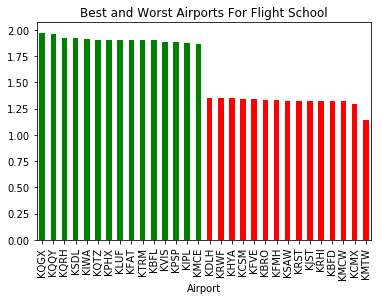

In [220]:
def assign_color(weather):
    '''
    Takes in weather condition
    from df_top_worst
    
    returns a color that will
    be used in the chart
    
    Output = 'g' means good weather
    Output = 'r' means bad weather
    '''
    if weather > 1.5:
        color = 'g'
    else:
        color = 'r'
    return color

df_color = df_top_worst['weather'].apply(assign_color)

df_top_worst.plot(x = 'airport', y = 'weather', kind = 'bar', legend = False, title = 'Best and Worst Airports For Flight School', color = df_color)

plt.xlabel("Airport")

plt.savefig('Airport.png')